# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy.signal import fftconvolve
from scipy.stats import norm
import pickle

# Read functions from parent folder:
sys.path.append('./experiment')
from params import stim_params

sys.path.append('./simulations')
from functions import create_loggabors, create_loggabors_fft, load_all_data, \
    reformat_data, create_edge, pull_noise_mask, run_model, naka_rushton


same_instance = True
results_file = "./simulations/multi_dprime_30_dif_crop.pickle"
cropping = True

# Helper functions

In [2]:
def plot_filters(arr, extent, clim=None):
    plt.figure(figsize=(18, 4))
    if type(arr) is list:
        nplots = len(arr)
        for i in range(nplots):
            plt.subplot(1, nplots, i+1)
            if clim is None:
                plt.imshow(arr[i], cmap='coolwarm')
            else:
                plt.imshow(arr[i], cmap='coolwarm', vmin=clim[0], vmax=clim[1])
            plt.colorbar()
    else:
        nplots = arr.shape[-1]
        for i in range(nplots):
            plt.subplot(1, nplots, i+1)
            if clim is None:
                plt.imshow(arr[:, :, i], cmap='coolwarm')
            else:
                plt.imshow(arr[:, :, i], cmap='coolwarm', vmin=clim[0], vmax=clim[1])
            plt.colorbar()
    plt.show()

def plot_filters_cut(arr):
    if type(arr) is list:
        nplots = len(arr)
    else:
        nplots = arr.shape[-1]
    plt.figure(figsize=(18, 4))
    for i in range(nplots):
        cut = int(arr[i].shape[0]/2)
        plt.subplot(1, nplots, i+1)
        plt.plot(arr[i][cut,:])
    plt.show()

def load_pickle(results_file):
    # Load data from pickle:
    with open(results_file, 'rb') as handle:
        data_pickle = pickle.load(handle)

    best_params = data_pickle["best_params_auto"]
    return best_params

def crop_outputs(array, rb):
    array_shape = array.shape
    array = array[:, rb:array_shape[1]-rb, :]
    return array

# Get experimental data

We first load the data from all observers.

In [3]:
vps = ["ls"]
n_vps = len(vps)

# Load data
datadir = "./experiment/results/"
data = load_all_data(datadir, vps)

Note:
We currently bin trials with similar edge contrasts to reduce the number of model runs during the optimization.

In [4]:
reduce_data = True
nbins = 5

# Reformat data
noise_conds = np.unique(data["noise"])
edge_conds = np.unique(data["edge_width"])

df_list = []
for n in noise_conds:
    for e in edge_conds:
        contrasts, ncorrect, ntrials = reformat_data(data, n, e)
        
        if reduce_data:
            bins = np.linspace(contrasts.min(), contrasts.max(), nbins+1)
            digitized = np.digitize(contrasts, bins)
            digitized[digitized>nbins] = nbins
            contrasts = np.array([contrasts[digitized == i].mean() for i in range(1, nbins+1)])
            ncorrect = np.array([ncorrect[digitized == i].sum() for i in range(1, nbins+1)])
            ntrials = np.array([ntrials[digitized == i].sum() for i in range(1, nbins+1)])

        df = pd.DataFrame({
            "noise": [n,]*len(contrasts),
            "edge": [e,]*len(contrasts),
            "contrasts": contrasts,
            "ncorrect": ncorrect,
            "ntrials": ntrials,
            })
        df_list.append(df)
df = pd.concat(df_list).reset_index(drop=True)

Let's plot the data for one example condition.

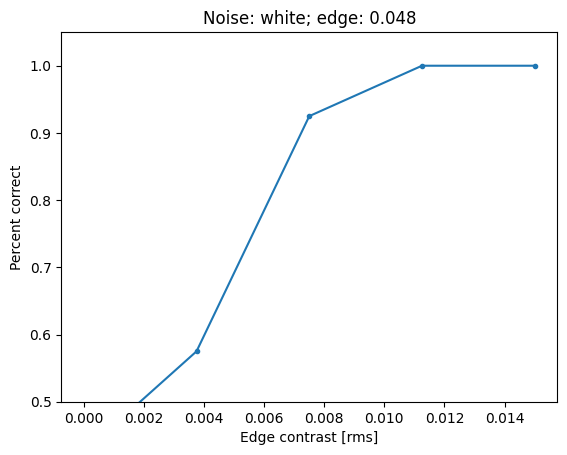

In [5]:
this_c = 0.015
this_ncond = noise_conds[6]
this_econd = edge_conds[0]
data_cond = df[(df["noise"]==this_ncond) & (df["edge"]==this_econd)]

# Plotting
plt.plot(data_cond["contrasts"], data_cond["ncorrect"] / data_cond["ntrials"], ".-")
plt.ylim(0.5, 1.05), plt.title("Noise: " + this_ncond + "; edge: " + str(this_econd))
plt.ylabel("Percent correct"), plt.xlabel("Edge contrast [rms]")
plt.show()

# Prepare stimulus

We will demonstrate how the model works for one example stimulus.
We will choose the same stimulus condition as shown above and use a relatively large edge contrast given the above psychometric curve.

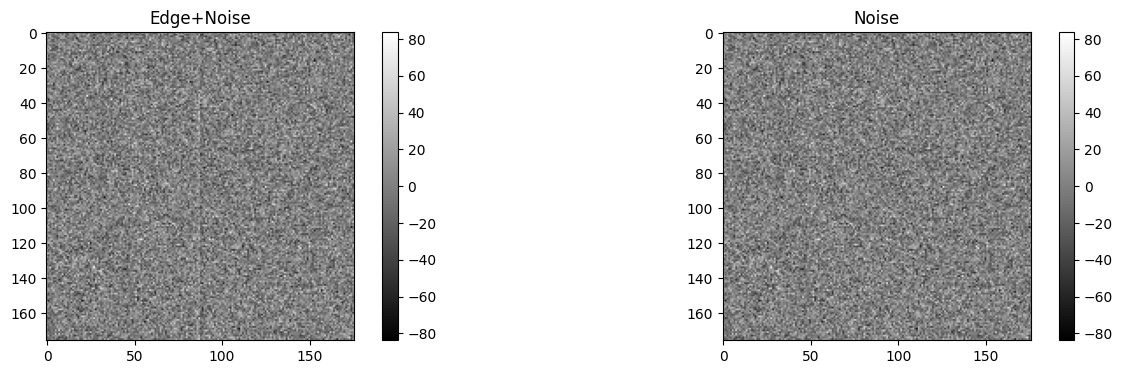

In [6]:
noise = pull_noise_mask(this_ncond, stim_params, 0, "./simulations/noise_masks/")
noise2 = pull_noise_mask(this_ncond, stim_params, 1, "./simulations/noise_masks/")
edge = create_edge(this_c, this_econd, stim_params) - stim_params["mean_lum"]

if same_instance:
    stim = edge + noise
else:
    stim = edge + noise2

vmax = np.abs(stim).max()
plt.figure(figsize=(16, 4))
plt.subplot(121), plt.imshow(stim, cmap='gray', vmin=-vmax, vmax=vmax), plt.colorbar(), plt.title("Edge+Noise")
plt.subplot(122), plt.imshow(noise, cmap='gray', vmin=-vmax, vmax=vmax), plt.colorbar(), plt.title("Noise")
plt.show()

# The model

## Model architecture ("physiology")

The model consists of multiple log-Gabor filters with center SFs in octave intervals.
Here is an overview of the model parameters.
All parameters are inspired by physiological findings about cells in V1.

In [7]:
# Parameters
fos = [0.5, 3., 9.]              # center SFs of log-Gabor filters
sigma_fo = 0.5945                # from Schütt & Wichmann (2017)
sigma_angleo = 0.2965            # from Schütt & Wichmann (2017)
n_filters = len(fos)

print(fos)


# Some preparations
ppd = stim_params["ppd"]
vextent = [-stim_params["stim_size"]/2, stim_params["stim_size"]/2,] * 2
fac = int(ppd*2)  # padding to avoid border artefacts

# Calculate spatial frequency axis in cpd:
nX = int(stim_params["stim_size"] * ppd)
fs = np.fft.fftshift(np.fft.fftfreq(int(nX), d=1./ppd))
fextent = [fs[0], fs[-1],] * 2
fx, fy = np.meshgrid(fs, fs)

# Create loggabor filters
loggabors = create_loggabors(fx, fy, fos, sigma_fo, 0., sigma_angleo)
loggabors_fft = create_loggabors_fft(fx, fy, fos, sigma_fo, 0., sigma_angleo)

# Write relevant model variables in a dict
mparams = {"n_filters": n_filters,
           "fos": fos,
           "sigma_fo": sigma_fo,
           "sigma_angleo": sigma_angleo,
           "loggabors": loggabors,
           "fac": fac,
           "nX": nX,
           }

[0.5, 3.0, 9.0]


Image space


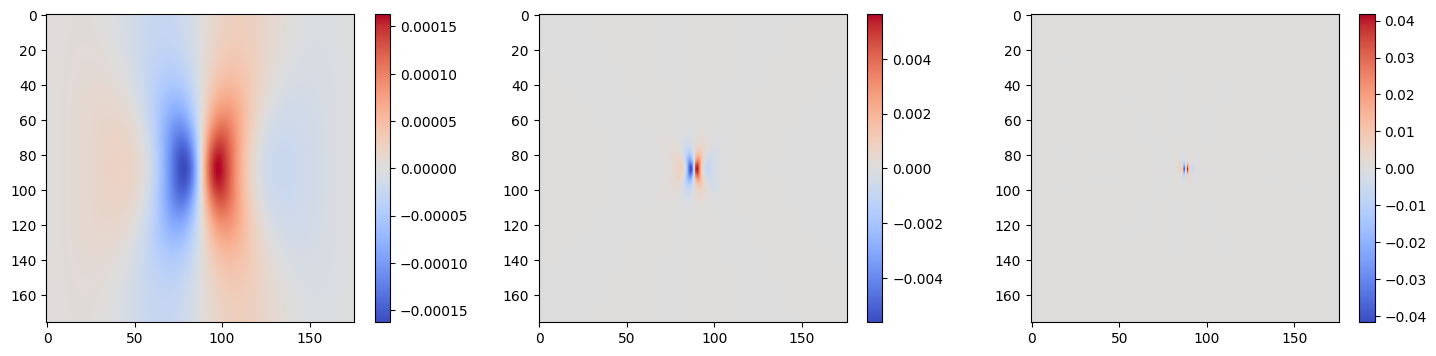

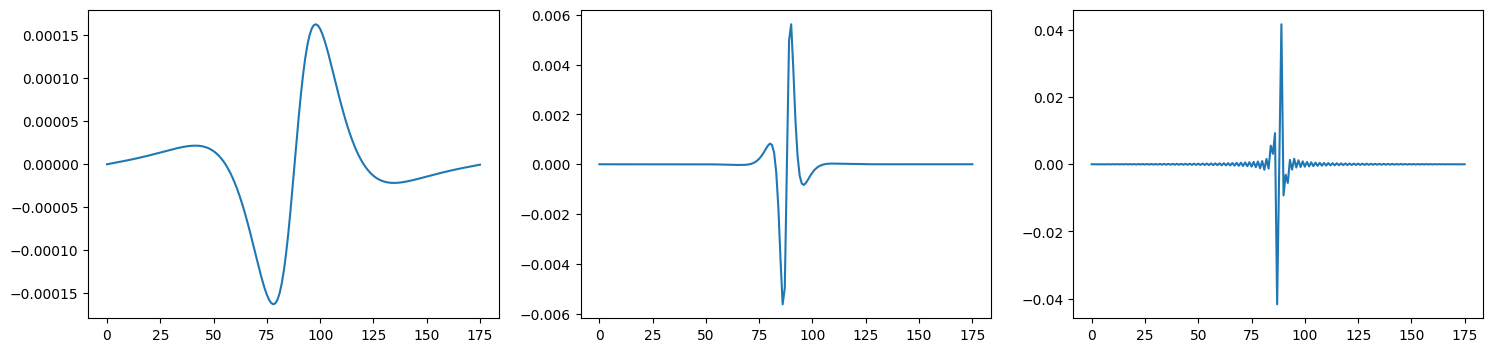

Frequency space


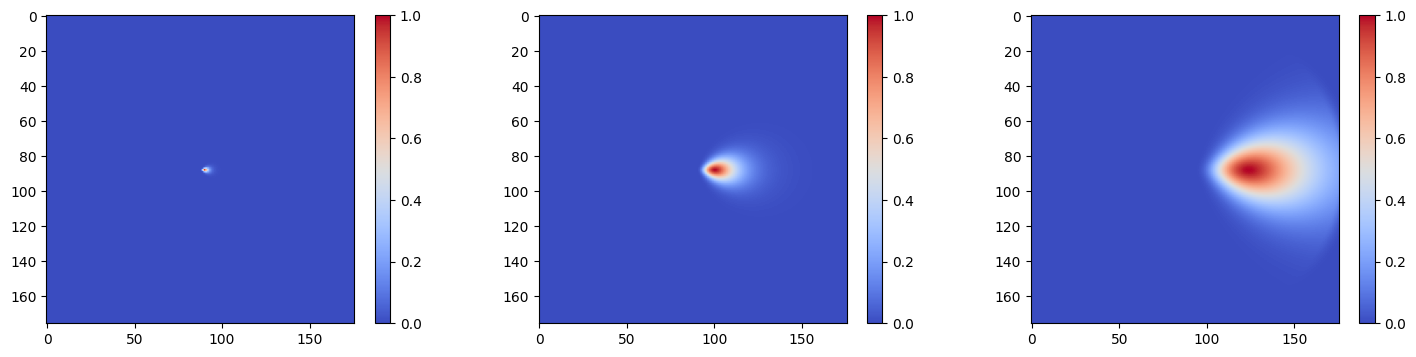

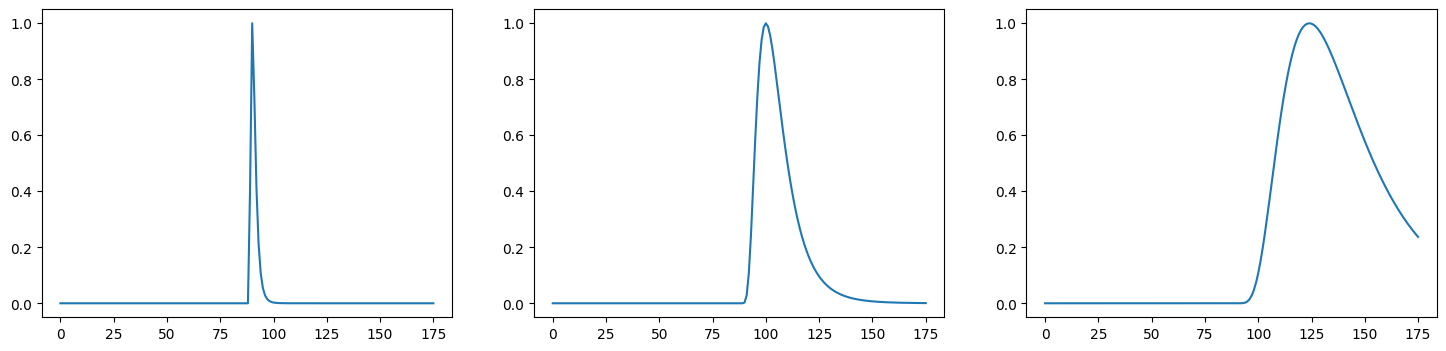

In [8]:
# Plot model filters
print("Image space")
plot_filters(loggabors, vextent)      # Image-space
plot_filters_cut(loggabors)           # Luminance profile

print("Frequency space")
plot_filters(loggabors_fft, fextent)  # Frequency space
plot_filters_cut(loggabors_fft)       # Cut-through

## Apply filters (ie SF channels)

In [9]:
# Run model on both stims
mout1 = run_model(stim, mparams)
mout2 = run_model(noise, mparams)

# Weight by stimulus profile
sweight = np.expand_dims(np.abs(edge - edge.mean()), -1)
mout1 = mout1 * sweight/sweight.max()
mout2 = mout2 * sweight/sweight.max()

Edge + noise


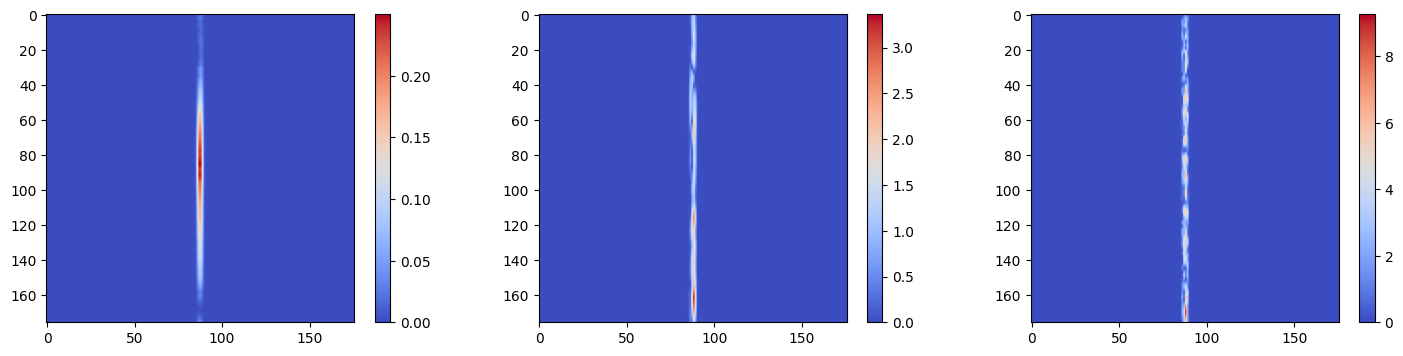

Noise


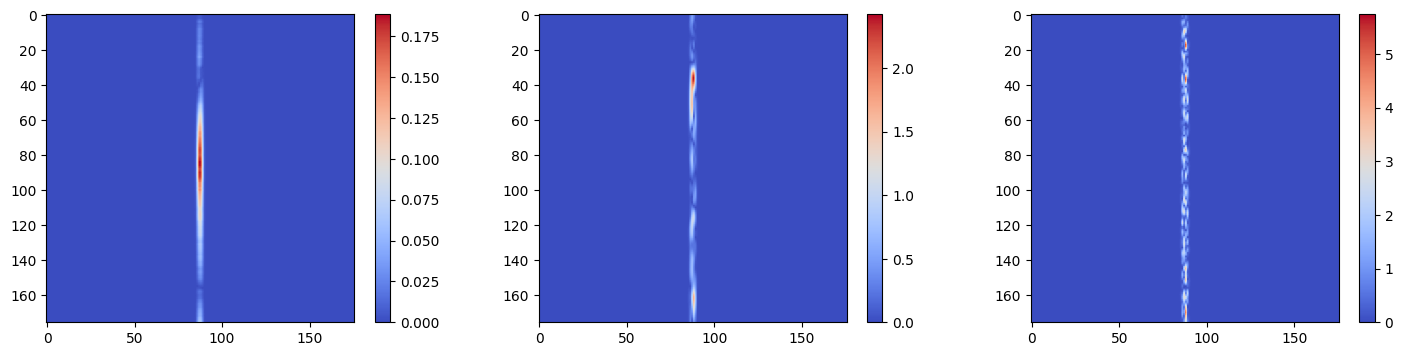

In [10]:
# Plot model outputs
print("Edge + noise")
plot_filters(mout1, vextent)

print("Noise")
plot_filters(mout2, vextent)

## Divisive contrast gain control
... modeled as Naka-Rushton function:

$\Large \frac{ \alpha_i x_i^{\eta + \kappa}}{ x_i^{\kappa} + \beta}$, 

where $\alpha_i$, $\beta$, $\eta$, and $\kappa$ are fitted hyperparameters, where $x_i$ inicates the filter outputs and where $i$ indicates each channel.

Note:
This specific parameterization of Naka-Rushton has been used in Wichmann (1999).
We use it because then we can directly compare the magnitude of the parameters with the ones from the spatial vision literature.

### Fitted parameters

The current best model has the following fitted parameters:

In [11]:
# Load params
params_dict = load_pickle(results_file)

# Reformat to pass into following functions
beta = params_dict["beta"]
eta = params_dict["eta"]
kappa = params_dict["kappa"]
alphas = [params_dict["alpha"],
          params_dict["alpha2"],
          params_dict["alpha3"],
         ]

### Behavior of Naka-Rushtons

Let's look at the behavior of the Naka-Rushtons with the above specified parameters.

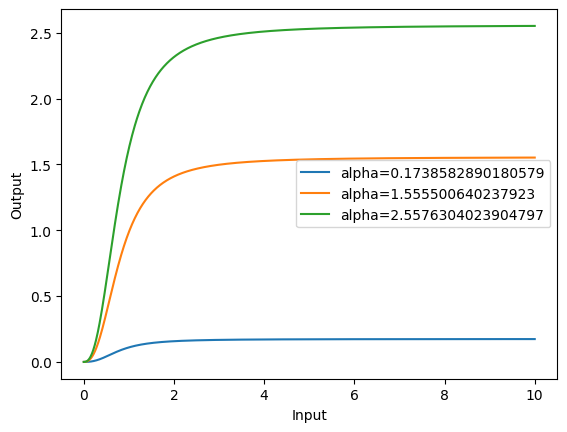

In [12]:
toy_x = np.linspace(0, 10, 1000)
for i in range(n_filters):
    plt.plot(toy_x, np.squeeze(naka_rushton(toy_x, alphas[i], beta, eta, kappa)), label="alpha=" + str(alphas[i]))
    plt.ylabel("Output"), plt.xlabel("Input")
plt.legend()
plt.show()

### Apply gain control to each individual neuron

Now, let's apply our Naka-Rushtons to our filter outputs.

In [13]:
mout1n = naka_rushton(mout1, alphas, beta, eta, kappa)
mout2n = naka_rushton(mout2, alphas, beta, eta, kappa)

if cropping:
    mout1n = crop_outputs(mout1n, int(ppd*0.75))
    mout2n = crop_outputs(mout2n, int(ppd*0.75))

Edge + noise


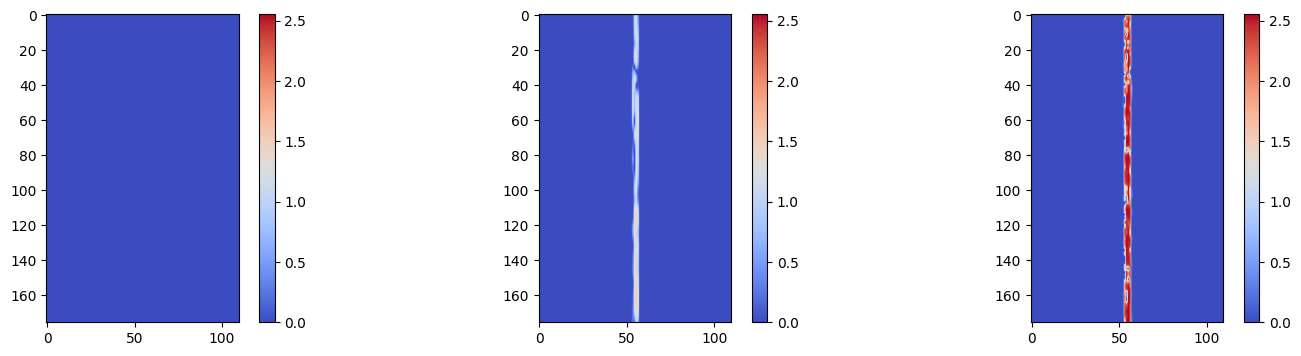

Noise


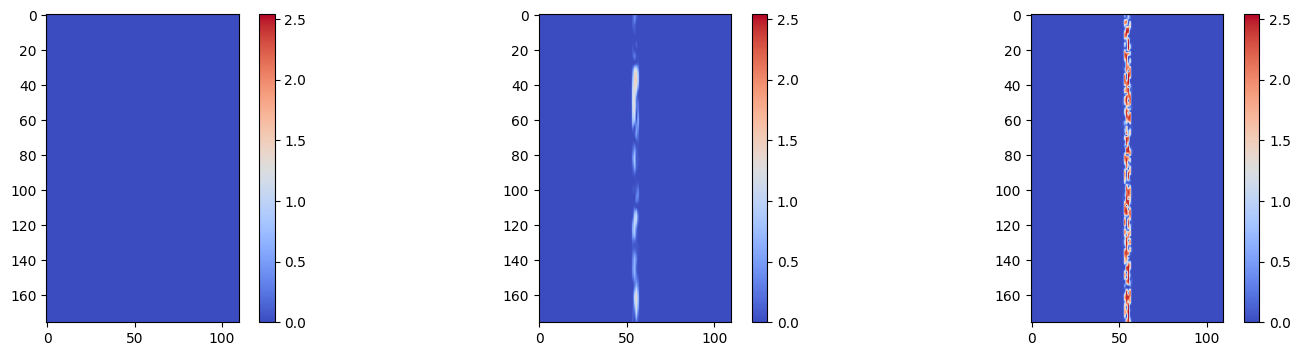

Difference


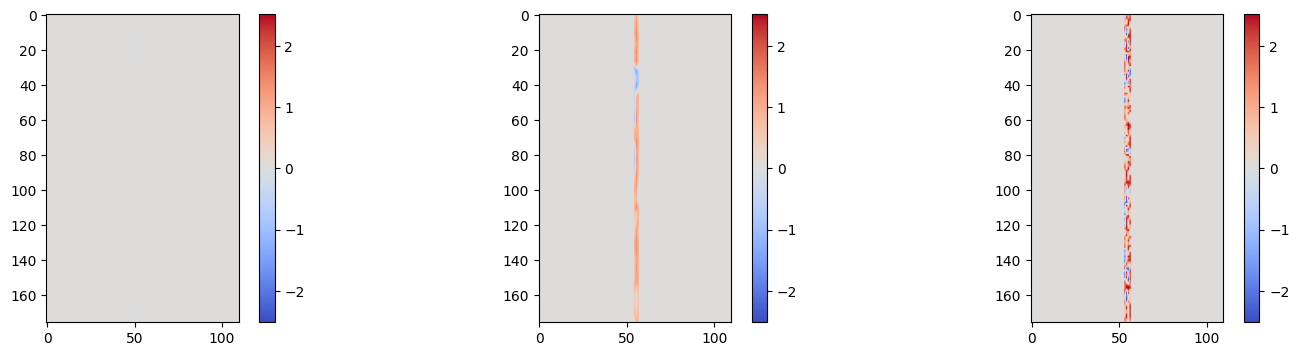

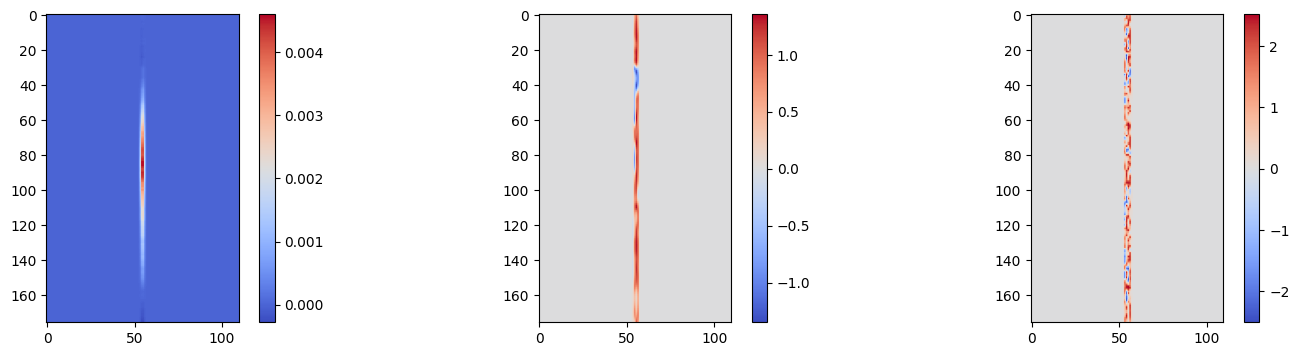

In [14]:
# Visualize
print("Edge + noise")
plot_filters(mout1n, vextent, [mout1n.min(), mout1n.max()])

print("Noise")
plot_filters(mout2n, vextent, [mout2n.min(), mout2n.max()])

print("Difference")
mdif = mout1n-mout2n
plot_filters(mdif, vextent, [-np.abs(mdif).max(), np.abs(mdif).max()])
plot_filters(mdif, vextent)

# Decoding

So far, all noise sources are external (ie in the stimulus).

In signal detection theory, we assume that the system itself is noisy.
We assume this internal/decision noise to be Gaussian-distributed with zero-mean and independent for each neuron (ie each pixel in the filter outputs).

We could fit the noise parameter to our data.
However, to avoid correlations with the Naka-Rushton-parameters, we set it to unit-variance.

In [15]:
# Parameters
noise_var = 1   # magnitude of internal / decision noise
lamb = 0.005    # lapse rate (calculate from our data? -> psignifit)

# We use unit variance for each neuron / pixel
noise_var = np.ones(mout1n.shape) * noise_var

## Calculate dprime

Classically, dprime for a 2AFC is defined as:

$ \large d' = \frac{ \mu }{ \sqrt{\sigma^2} } \quad $ with $\mu = \mu_{1} - \mu_{2}$

where $\mu_{1}$ is the mean for signal present and $\mu_{2}$ is the mean for signal absent, and $\sigma^2$ is the shared variance.

As far as I understood, we assume that each neuron is independent and thus sum the means and variance across neurons $i$ (ie sum their independent normal distributions) to compute dprime:
$\; \mu = \sum_{i=1}^{N} \mu_i \;$
and $\; \sigma^2 = \sum_{i=1}^{N} \sigma_{i}^{2}$.
These summed distributions are themselves normally distributed.

In [16]:
mu = (mout1n - mout2n).sum()
sigma_squared = noise_var.sum()

dprime = mu / np.sqrt(sigma_squared)
print("dprime:", dprime)

dprime: 3.6292601234822355


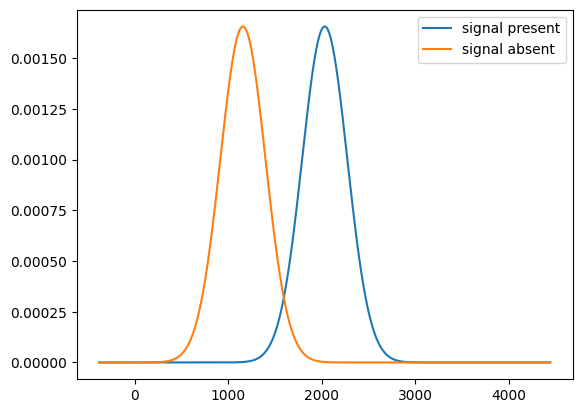

In [17]:
# Visualize summed distributions
mu1_sum = mout1n.sum()
mu2_sum = mout2n.sum()

xvals = np.linspace(mu1_sum-np.sqrt(sigma_squared)*10, mu1_sum+np.sqrt(sigma_squared)*10, 1000000)
plt.plot(xvals, norm.pdf(xvals, loc=mu1_sum, scale=np.sqrt(sigma_squared)), label="signal present")
plt.plot(xvals, norm.pdf(xvals, loc=mu2_sum, scale=np.sqrt(sigma_squared)), label="signal absent")
plt.legend()
plt.show()

This is probably the simplest form of a decoder.
In e.g. Schütt & Wichmann (2017), they have used two more complex decoders:
1. A decoder which weights the outputs of each neuron by how discriminative it is (weighting by signal-to-noise ratio `snr = (mout1-mout2) / noise_var`) and then `d = ( snr*(mout1-mout2) ).sum` and `sigma = sqrt( (snr**2 * noise_var).sum) )`
2. A decoder which weights all neurons equally but in the correct direction (ie calculates `d = abs(mout1-mout2).sum`)

In both cases, we cannot plot the signal-present and signal-absent distributions as shown above.

## Calculate percent-correct given cumulative normal distribution

In [18]:
# Get percent-correct given the cumulative normal distribution
pc = norm.cdf(dprime)
pc = lamb + (1. - 2.*lamb) * pc  # consider lapses

print("Percent-correct", pc)

Percent-correct 0.9948593038159823


# On gain control ...

Reviewer 1 commented to implement gain control in which the activity of different SF-channels affect each other (more similar SFs affect each other more).
However, physiological data suggests that the bandwidth of this pooling is about 1 octave.
Since the SFs of our channels are 0.5, 3 and 9 cpd, they basically dont affect each other (0.5: 0.25-1; 3: 1.5-6; 9: 4.5-18).

## Across frequencies

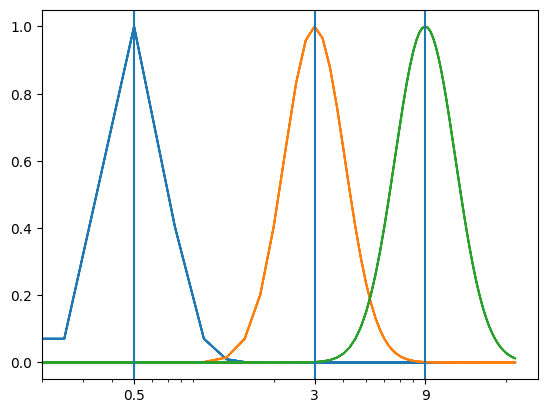

In [19]:
fo = 9
sigma_fo = 0.74
fr = np.abs(fs)

for fo in [0.5, 3, 9]:
    fr[int(nX/2)] = 1.

    # Calculate radial component of the filter:
    radial = np.exp((-(np.log(fr/fo))**2.) / (2. * np.log(sigma_fo)**2.))

    # Undo radius fudge
    radial[int(nX/2)] = 0.
    fr[int(nX/2)] = 0.

    plt.plot(fr, radial), plt.xscale('log')
plt.axvline(0.5), plt.axvline(3), plt.axvline(9)
plt.xticks([0.5, 3, 9], [0.5, 3, 9])
plt.show()

## Across space

94


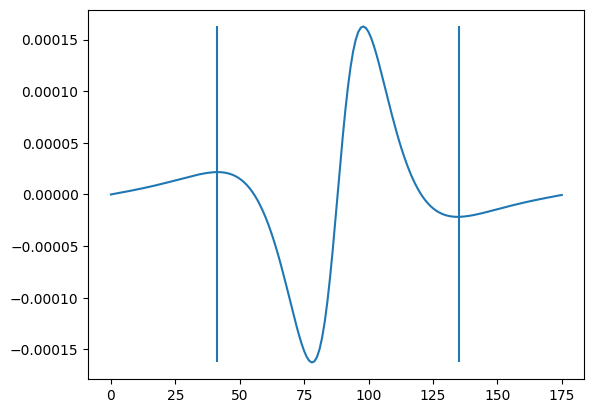

In [20]:
lg = loggabors[0][int(nX/2), :]

idx = np.argmax(lg[0:int(nX/2)])

plt.plot(lg)
plt.vlines(idx, lg.min(), lg.max())
plt.vlines(len(lg)-idx, lg.min(), lg.max())

print(len(lg)-idx*2)

In [21]:
mout1.shape

(176, 176, 3)

/tmp/ipykernel_281197/4251419678.py:9: RuntimeWarning: invalid value encountered in divide
  plt.subplot(133), plt.imshow(mout1[:,:,iF] / out), plt.colorbar()


(<Axes: >,
 <matplotlib.colorbar.Colorbar at 0x70bbf0b9b850>)

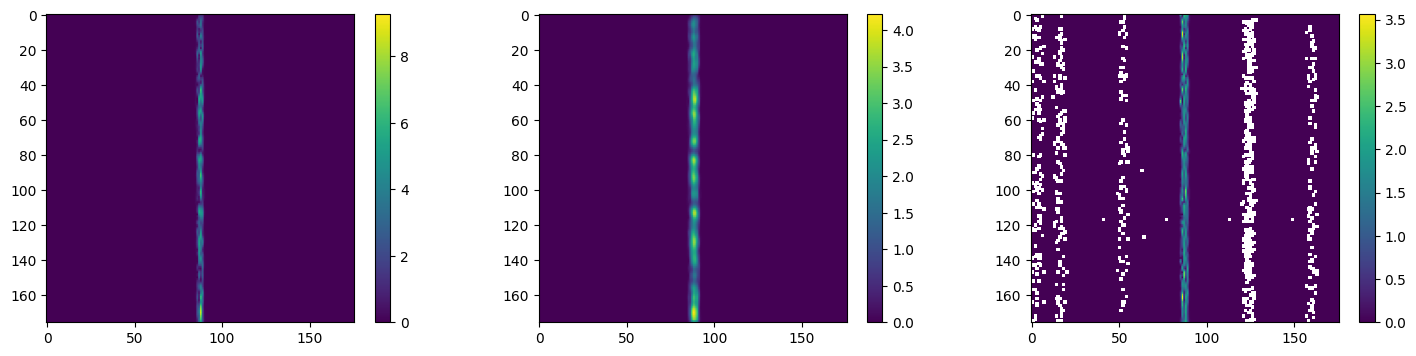

In [22]:
lgsize = [94, 16, 4]

iF = 2
out = fftconvolve(mout1[:,:,iF], np.ones([lgsize[iF], lgsize[iF]]) / lgsize[iF]**2., 'same')

plt.figure(figsize=(18, 4))
plt.subplot(131), plt.imshow(mout1[:,:,iF]), plt.colorbar()
plt.subplot(132), plt.imshow(out), plt.colorbar()
plt.subplot(133), plt.imshow(mout1[:,:,iF] / out), plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


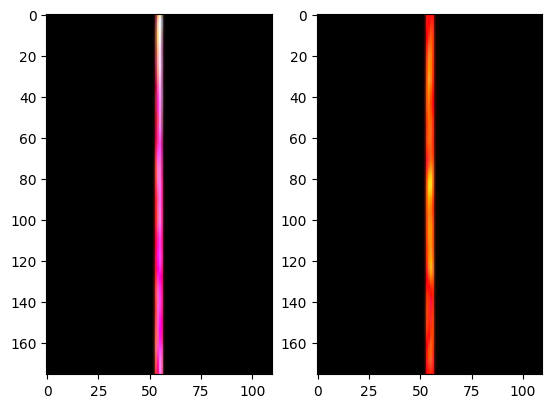

In [23]:
with open("./simulations/outputs_dif/pink2_0.048_4_0.pickle", 'rb') as handle:
    data_pickle = pickle.load(handle)

plt.subplot(121); plt.imshow(data_pickle["mout1"])
plt.subplot(122); plt.imshow(data_pickle["mout2"])